<a href="https://colab.research.google.com/github/prashantyadav05/PatientSurvival-Prediction/blob/main/PatientSurvivalPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix

from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, KFold

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import shap

pd.set_option('display.max_rows', 250)

raw_data = pd.read_csv("/content/Dataset.csv")
raw_data.head(2)

encounter_id  patient_id  hospital_id  hospital_death   age    bmi  \
0         66154       25312          118               0  68.0  22.73   
1        114252       59342           81               0  77.0  27.42   

   elective_surgery  ethnicity gender  height  ... aids cirrhosis  \
0                 0  Caucasian      M   180.3  ...  0.0       0.0   
1                 0  Caucasian      F   160.0  ...  0.0       0.0   

   diabetes_mellitus hepatic_failure immunosuppression  leukemia  lymphoma  \
0                1.0             0.0               0.0       0.0       0.0   
1                1.0             0.0               0.0       0.0       0.0   

   solid_tumor_with_metastasis  apache_3j_bodysystem  apache_2_bodysystem  
0                          0.0                Sepsis       Cardiovascular  
1                          0.0           Respiratory          Respiratory  

[2 rows x 186 columns]

In [3]:
raw_data.shape

(91713, 186)

In [4]:
raw_data.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 186 columns):
 #    Column                         Non-Null Count  Dtype  
---   ------                         --------------  -----  
 0    encounter_id                   91713 non-null  int64  
 1    patient_id                     91713 non-null  int64  
 2    hospital_id                    91713 non-null  int64  
 3    hospital_death                 91713 non-null  int64  
 4    age                            87485 non-null  float64
 5    bmi                            88284 non-null  float64
 6    elective_surgery               91713 non-null  int64  
 7    ethnicity                      90318 non-null  object 
 8    gender                         91688 non-null  object 
 9    height                         90379 non-null  float64
 10   hospital_admit_source          70304 non-null  object 
 11   icu_admit_source               91601 non-null  object 
 12   icu_id                        

In [5]:
raw_data.describe()

encounter_id     patient_id   hospital_id  hospital_death  \
count   91713.000000   91713.000000  91713.000000    91713.000000   
mean    65606.079280   65537.131464    105.669262        0.086302   
std     37795.088538   37811.252183     62.854406        0.280811   
min         1.000000       1.000000      2.000000        0.000000   
25%     32852.000000   32830.000000     47.000000        0.000000   
50%     65665.000000   65413.000000    109.000000        0.000000   
75%     98342.000000   98298.000000    161.000000        0.000000   
max    131051.000000  131051.000000    204.000000        1.000000   

                age           bmi  elective_surgery        height  \
count  87485.000000  88284.000000      91713.000000  90379.000000   
mean      62.309516     29.185818          0.183736    169.641588   
std       16.775119      8.275142          0.387271     10.795378   
min       16.000000     14.844926          0.000000    137.200000   
25%       52.000000     23.641975          0.000000    162.500000   
50%       65.000000     27.654655          0.000000    170.100000   
75%       75.000000     32.930206          0.000000    177.800000   
max       89.000000     67.814990          1.000000    195.590000   

             icu_id  pre_icu_los_days  ...  apache_4a_hospital_death_prob  \
count  91713.000000      91713.000000  ...                   83766.000000   
mean     508.357692          0.835766  ...                       0.086787   
std      228.989661          2.487756  ...                       0.247569   
min       82.000000        -24.947222  ...                      -1.000000   
25%      369.000000          0.035417  ...                       0.020000   
50%      504.000000          0.138889  ...                       0.050000   
75%      679.000000          0.409028  ...                       0.130000   
max      927.000000        159.090972  ...                       0.990000   

       apache_4a_icu_death_prob          aids     cirrhosis  \
count              83766.000000  90998.000000  90998.000000   
mean                   0.043955      0.000857      0.015693   
std                    0.217341      0.029265      0.124284   
min                   -1.000000      0.000000      0.000000   
25%                    0.010000      0.000000      0.000000   
50%                    0.020000      0.000000      0.000000   
75%                    0.060000      0.000000      0.000000   
max                    0.970000      1.000000      1.000000   

       diabetes_mellitus  hepatic_failure  immunosuppression      leukemia  \
count       90998.000000     90998.000000       90998.000000  90998.000000   
mean            0.225192         0.012989           0.026165      0.007066   
std             0.417711         0.113229           0.159628      0.083763   
min             0.000000         0.000000           0.000000      0.000000   
25%             0.000000         0.000000           0.000000      0.000000   
50%             0.000000         0.000000           0.000000      0.000000   
75%             0.000000         0.000000           0.000000      0.000000   
max             1.000000         1.000000           1.000000      1.000000   

           lymphoma  solid_tumor_with_metastasis  
count  90998.000000                 90998.000000  
mean       0.004132                     0.020638  
std        0.064148                     0.142169  
min        0.000000                     0.000000  
25%        0.000000                     0.000000  
50%        0.000000                     0.000000  
75%        0.000000                     0.000000  
max        1.000000                     1.000000  

[8 rows x 178 columns]

In [6]:
(raw_data.isnull().mean()*100).sort_values(ascending=False)

h1_bilirubin_min                 92.265001
h1_bilirubin_max                 92.265001
h1_lactate_max                   91.992411
h1_lactate_min                   91.992411
h1_albumin_max                   91.398166
h1_albumin_min                   91.398166
h1_pao2fio2ratio_min             87.441257
h1_pao2fio2ratio_max             87.441257
h1_arterial_ph_max               83.329517
h1_arterial_ph_min               83.329517
h1_hco3_max                      82.969699
h1_hco3_min                      82.969699
h1_arterial_pco2_min             82.822501
h1_arterial_pco2_max             82.822501
h1_wbc_max                       82.815958
h1_wbc_min                       82.815958
h1_arterial_po2_max              82.807236
h1_arterial_po2_min              82.807236
h1_calcium_max                   82.717826
h1_calcium_min                   82.717826
h1_platelets_max                 82.510658
h1_platelets_min                 82.510658
h1_bun_max                       81.876070
h1_bun_min 

Columns that can be dropped: **'encounter_id', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'patient_id', 'hospital_id', 'readmission_status'**

Notice the amount of missing values in each row. We decide a threshold value to delete some of the attributes from the dataset (25k in this approach)  **74** columns will get deleted in this turn.

In [7]:
print("Number of rows with missing values:", raw_data.isnull().any(axis=1).sum())

Number of rows with missing values: 91688


In [8]:
large_missing = raw_data.isnull().sum(axis=0).sort_values(ascending=False)[raw_data.isnull().sum(axis=0).sort_values(ascending=False) > 25000]

print("\nTotal features with more than", 25000, "missing values:", len(large_missing))

raw_data.drop(large_missing.index.tolist() + ['encounter_id', 'hospital_admit_source', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'patient_id', 'hospital_id', 'readmission_status'], axis=1, inplace = True)
raw_data


Total features with more than 25000 missing values: 74


hospital_death   age        bmi  elective_surgery  ethnicity gender  \
0                   0  68.0  22.730000                 0  Caucasian      M   
1                   0  77.0  27.420000                 0  Caucasian      F   
2                   0  25.0  31.950000                 0  Caucasian      F   
3                   0  81.0  22.640000                 1  Caucasian      F   
4                   0  19.0        NaN                 0  Caucasian      M   
...               ...   ...        ...               ...        ...    ...   
91708               0  75.0  23.060250                 0  Caucasian      M   
91709               0  56.0  47.179671                 0  Caucasian      F   
91710               0  48.0  27.236914                 0  Caucasian      M   
91711               0   NaN  23.297481                 0  Caucasian      F   
91712               0  82.0  22.031250                 1  Caucasian      F   

       height      icu_type  pre_icu_los_days  weight  ...  aids  cirrhosis  \
0       180.3         CTICU          0.541667    73.9  ...   0.0        0.0   
1       160.0  Med-Surg ICU          0.927778    70.2  ...   0.0        0.0   
2       172.7  Med-Surg ICU          0.000694    95.3  ...   0.0        0.0   
3       165.1         CTICU          0.000694    61.7  ...   0.0        0.0   
4       188.0  Med-Surg ICU          0.073611     NaN  ...   0.0        0.0   
...       ...           ...               ...     ...  ...   ...        ...   
91708   177.8   Cardiac ICU          0.298611    72.9  ...   0.0        0.0   
91709   183.0  Med-Surg ICU          0.120139   158.0  ...   0.0        0.0   
91710   170.2  Med-Surg ICU          0.046528    78.9  ...   0.0        0.0   
91711   154.9  Med-Surg ICU          0.081944    55.9  ...   0.0        0.0   
91712   160.0  Med-Surg ICU          0.018056    56.4  ...   0.0        0.0   

       diabetes_mellitus  hepatic_failure  immunosuppression  leukemia  \
0                    1.0              0.0                0.0       0.0   
1                    1.0              0.0                0.0       0.0   
2                    0.0              0.0                0.0       0.0   
3                    0.0              0.0                0.0       0.0   
4                    0.0              0.0                0.0       0.0   
...                  ...              ...                ...       ...   
91708                1.0              0.0                0.0       0.0   
91709                0.0              0.0                0.0       0.0   
91710                1.0              0.0                0.0       0.0   
91711                0.0              0.0                0.0       0.0   
91712                0.0              0.0                0.0       0.0   

       lymphoma  solid_tumor_with_metastasis  apache_3j_bodysystem  \
0           0.0                          0.0                Sepsis   
1           0.0                          0.0           Respiratory   
2           0.0                          0.0             Metabolic   
3           0.0                          0.0        Cardiovascular   
4           0.0                          0.0                Trauma   
...         ...                          ...                   ...   
91708       0.0                          1.0                Sepsis   
91709       0.0                          0.0                Sepsis   
91710       0.0                          0.0             Metabolic   
91711       0.0                          0.0           Respiratory   
91712       0.0                          0.0      Gastrointestinal   

       apache_2_bodysystem  
0           Cardiovascular  
1              Respiratory  
2                Metabolic  
3           Cardiovascular  
4                   Trauma  
...                    ...  
91708       Cardiovascular  
91709       Cardiovascular  
91710            Metabolic  
91711          Respiratory  
91712     Gastrointestinal  

[91713 rows x 104 columns]

In [9]:
raw_data.nunique()

hospital_death                       2
age                                 74
bmi                              34888
elective_surgery                     2
ethnicity                            6
gender                               2
height                             401
icu_type                             8
pre_icu_los_days                  9757
weight                            3409
apache_2_diagnosis                  44
apache_3j_diagnosis                399
apache_post_operative                2
arf_apache                           2
bun_apache                         476
creatinine_apache                 1127
gcs_eyes_apache                      4
gcs_motor_apache                     6
gcs_unable_apache                    2
gcs_verbal_apache                    5
glucose_apache                     565
heart_rate_apache                  149
hematocrit_apache                  353
intubated_apache                     2
map_apache                         161
resprate_apache          

Removing missing values from some of the inter-related columns (bmi, weight and height). We cut down almost 3000 instances with this process safely.

In [10]:
raw_data = raw_data[raw_data[['bmi', 'weight', 'height']].isna().sum(axis=1) == 0]
raw_data

hospital_death   age        bmi  elective_surgery  ethnicity gender  \
0                   0  68.0  22.730000                 0  Caucasian      M   
1                   0  77.0  27.420000                 0  Caucasian      F   
2                   0  25.0  31.950000                 0  Caucasian      F   
3                   0  81.0  22.640000                 1  Caucasian      F   
5                   0  67.0  27.560000                 0  Caucasian      M   
...               ...   ...        ...               ...        ...    ...   
91708               0  75.0  23.060250                 0  Caucasian      M   
91709               0  56.0  47.179671                 0  Caucasian      F   
91710               0  48.0  27.236914                 0  Caucasian      M   
91711               0   NaN  23.297481                 0  Caucasian      F   
91712               0  82.0  22.031250                 1  Caucasian      F   

       height      icu_type  pre_icu_los_days  weight  ...  aids  cirrhosis  \
0       180.3         CTICU          0.541667    73.9  ...   0.0        0.0   
1       160.0  Med-Surg ICU          0.927778    70.2  ...   0.0        0.0   
2       172.7  Med-Surg ICU          0.000694    95.3  ...   0.0        0.0   
3       165.1         CTICU          0.000694    61.7  ...   0.0        0.0   
5       190.5  Med-Surg ICU          0.000694   100.0  ...   0.0        0.0   
...       ...           ...               ...     ...  ...   ...        ...   
91708   177.8   Cardiac ICU          0.298611    72.9  ...   0.0        0.0   
91709   183.0  Med-Surg ICU          0.120139   158.0  ...   0.0        0.0   
91710   170.2  Med-Surg ICU          0.046528    78.9  ...   0.0        0.0   
91711   154.9  Med-Surg ICU          0.081944    55.9  ...   0.0        0.0   
91712   160.0  Med-Surg ICU          0.018056    56.4  ...   0.0        0.0   

       diabetes_mellitus  hepatic_failure  immunosuppression  leukemia  \
0                    1.0              0.0                0.0       0.0   
1                    1.0              0.0                0.0       0.0   
2                    0.0              0.0                0.0       0.0   
3                    0.0              0.0                0.0       0.0   
5                    1.0              0.0                0.0       0.0   
...                  ...              ...                ...       ...   
91708                1.0              0.0                0.0       0.0   
91709                0.0              0.0                0.0       0.0   
91710                1.0              0.0                0.0       0.0   
91711                0.0              0.0                0.0       0.0   
91712                0.0              0.0                0.0       0.0   

       lymphoma  solid_tumor_with_metastasis  apache_3j_bodysystem  \
0           0.0                          0.0                Sepsis   
1           0.0                          0.0           Respiratory   
2           0.0                          0.0             Metabolic   
3           0.0                          0.0        Cardiovascular   
5           0.0                          0.0          Neurological   
...         ...                          ...                   ...   
91708       0.0                          1.0                Sepsis   
91709       0.0                          0.0                Sepsis   
91710       0.0                          0.0             Metabolic   
91711       0.0                          0.0           Respiratory   
91712       0.0                          0.0      Gastrointestinal   

       apache_2_bodysystem  
0           Cardiovascular  
1              Respiratory  
2                Metabolic  
3           Cardiovascular  
5               Neurologic  
...                    ...  
91708       Cardiovascular  
91709       Cardiovascular  
91710            Metabolic  
91711          Respiratory  
91712     Gastrointestinal  

[88284 rows x 104 columns]

### Univariate-Multivariate Analysis

Individual plots seldom doesn't help in large datasets, in this approach let's look at the variation of instances according to each context of the column


The death rate for Male-Female patients is shown below. While the rate of  female deaths</span>** are higher. the youngest person to pass away during one of the case was a Male of **16yrs** of age

In [11]:
fig = px.histogram(raw_data[['age','gender','hospital_death','bmi']].dropna(), x="age", y="hospital_death", color="gender", marginal="box", hover_data=raw_data[['age','gender','hospital_death','bmi']].columns)

fig.show()

Average hospital death probability of patients based on age and gender:

In [12]:
age_death_F=raw_data[raw_data['gender']=='F'][['age','hospital_death']].groupby('age').mean().reset_index()
age_death_M=raw_data[raw_data['gender']=='M'][['age','hospital_death']].groupby('age').mean().reset_index()

fig = make_subplots()
fig.add_trace(go.Scatter(x=age_death_F['age'], y=age_death_F['hospital_death'], name="Female patients"))
fig.add_trace(go.Scatter(x=age_death_M['age'], y=age_death_M['hospital_death'], name="Male patients"))
fig.update_layout(title_text="<b>Average hospital death probability of patients<b>")
fig.update_xaxes(title_text="<b>patient age<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death</b>", secondary_y=False)
fig.show()

### Impact of BMI and weight over patients:

In [13]:
weight_df=raw_data[['weight','hospital_death','bmi']]
weight_df['weight']=weight_df['weight'].round(0)
weight_df['bmi']=weight_df['bmi'].round(0)
weight_death=weight_df[['weight','hospital_death']].groupby('weight').mean().reset_index()
bmi_death=weight_df[['bmi','hospital_death']].groupby('bmi').mean().reset_index()

fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(go.Scatter(x=weight_death['weight'], y=weight_death['hospital_death'], name="Weight"), row=1, col=1)
fig.add_trace(go.Scatter(x=bmi_death['bmi'], y=bmi_death['hospital_death'], name="BMI"), row=1, col=2)
fig.update_layout(title_text="<b>impacts of BMI and weight over patients<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death")
fig.show()

### Survival rate at different types of ICU:

some of the ICU wards have higher death probability pertaining to being surgical wards

In [14]:
ICU_type=raw_data[['icu_type','age','hospital_death']]
ICU_type['icu_type']=ICU_type['icu_type'].replace({'CTICU':'CCU-CTICU', 'Cardiac ICU':'CCT-CTICU', 'CTICU':'CCT-CTICU', 'CSICU':'SICU'})
#ICU_type['pre_icu_los_days']=ICU_type['pre_icu_los_days'].round(0)
ICU_df=ICU_type.groupby(['icu_type','age']).mean().reset_index()
ICU_df['count']=ICU_type.groupby(['icu_type','age']).count().reset_index()['hospital_death']

fig = px.scatter(ICU_df, x="age", y="hospital_death", size="count", color="icu_type", hover_name="icu_type", log_x=False, size_max=60,)
fig.update_layout(title_text="<b>Survival rate at different types of ICU<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death<b>")
fig.update_xaxes(title_text="<b>Age<b>")
fig.show()

### Hospital Death Rate, by age and Medical condition:


In [15]:
apache3=raw_data[['age','apache_3j_bodysystem','hospital_death']]
apache3=apache3.groupby(['apache_3j_bodysystem','age']).agg(['size','mean']).reset_index()

apache3['size']=apache3['hospital_death']['size']
apache3['mean']=apache3['hospital_death']['mean']

apache3.drop('hospital_death',axis=1,inplace=True)

systems =list(apache3['apache_3j_bodysystem'].unique())
data = []
list_updatemenus = []
for n, s in enumerate(systems):
    visible = [False] * len(systems)
    visible[n] = True
    temp_dict = dict(label = str(s), method = 'update', args = [{'visible': visible}, {'title': '<b>'+s+'<b>'}])
    list_updatemenus.append(temp_dict)
    

for s in systems:
    mask = (apache3['apache_3j_bodysystem'].values == s) 
    trace = (dict(visible = False,  x = apache3.loc[mask, 'age'],  y = apache3.loc[mask, 'mean'],  mode = 'markers',  marker = {'size':apache3.loc[mask, 'size']/apache3.loc[mask,'size'].sum()*1000, 'color':apache3.loc[mask, 'mean'], 'showscale': True}))
    data.append(trace)

data[0]['visible'] = True    
    
layout = dict(updatemenus=list([dict(buttons= list_updatemenus)]), xaxis=dict(title = '<b>Age<b>', range=[min(apache3.loc[:, 'age'])-10, max(apache3.loc[:, 'age']) + 10]), yaxis=dict(title = '<b>Average Hospital Death<b>', range=[min(apache3.loc[:, 'mean'])-0.1, max(apache3.loc[:, 'mean'])+0.1]), title='<b>Survival Rate<b>' )
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='update_dropdown')

**Density Distribution for numerical columns**

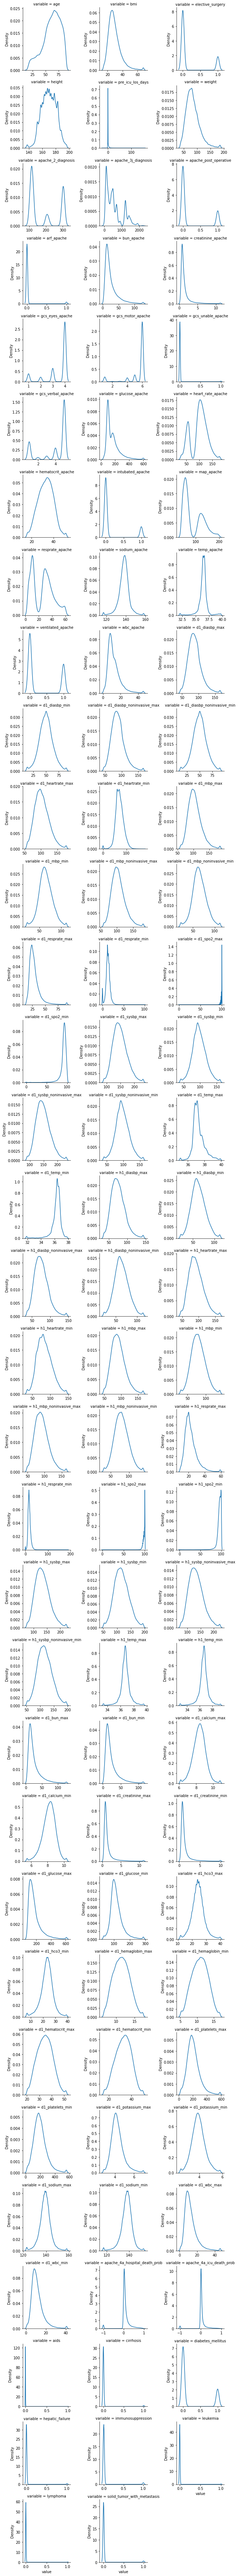

In [16]:
unpivot = pd.melt(raw_data, raw_data.describe().columns[0], raw_data.describe().columns[1:])

g = sns.FacetGrid(unpivot, col="variable", col_wrap=3, sharex=False, sharey=False)
g.map(sns.kdeplot, "value")

plt.show()

# Preprocessing

converting categorical values  
tranforming numerical columns and removing nulls

Null values for *categories* are replaced by **mode**, and those for *numerical* are replaced by **mean**

In [17]:
numerical_cat = ['elective_surgery','apache_post_operative','arf_apache','gcs_unable_apache','intubated_apache','ventilated_apache','aids','cirrhosis','diabetes_mellitus','hepatic_failure','immunosuppression','leukemia','lymphoma','solid_tumor_with_metastasis']

categorical = ['ethnicity','gender','icu_type','apache_3j_bodysystem','apache_2_bodysystem']


In [18]:
raw_data.nunique()[raw_data.nunique() == 2].index.tolist()

['hospital_death',
 'elective_surgery',
 'gender',
 'apache_post_operative',
 'arf_apache',
 'gcs_unable_apache',
 'intubated_apache',
 'ventilated_apache',
 'aids',
 'cirrhosis',
 'diabetes_mellitus',
 'hepatic_failure',
 'immunosuppression',
 'leukemia',
 'lymphoma',
 'solid_tumor_with_metastasis']

In [19]:
raw_data.select_dtypes(include='O').columns.values.tolist()

['ethnicity',
 'gender',
 'icu_type',
 'apache_3j_bodysystem',
 'apache_2_bodysystem']

In [20]:
not_numeric = raw_data[numerical_cat + categorical + ['hospital_death']].columns.tolist()
numeric_only = raw_data.drop(not_numeric,axis=1).columns.tolist()
numeric_only

['age',
 'bmi',
 'height',
 'pre_icu_los_days',
 'weight',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'bun_apache',
 'creatinine_apache',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'map_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'wbc_apache',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_max',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_max',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_mbp_noninvasive_max',
 'h1_mbp_noninvasive_min',
 'h1_re

In [21]:
for col in numerical_cat:
    raw_data[col] = raw_data[col].astype('Int64')
    
for col in numerical_cat:
    raw_data[col] = raw_data[col].fillna(raw_data[col].mode()[0])

In [22]:
raw_data[numeric_only].isna().sum(axis=0).sort_values(ascending=False)

wbc_apache                       21063
h1_temp_max                      20833
h1_temp_min                      20833
hematocrit_apache                19005
bun_apache                       18289
creatinine_apache                17926
sodium_apache                    17644
d1_hco3_max                      14390
d1_hco3_min                      14390
d1_platelets_min                 12767
d1_platelets_max                 12767
d1_wbc_max                       12501
d1_wbc_min                       12501
d1_calcium_min                   12315
d1_calcium_max                   12315
d1_hemaglobin_max                11519
d1_hemaglobin_min                11519
d1_hematocrit_max                11051
d1_hematocrit_min                11051
glucose_apache                   10473
d1_bun_min                        9860
d1_bun_max                        9860
d1_creatinine_min                 9561
d1_creatinine_max                 9561
d1_sodium_max                     9554
d1_sodium_min            

In [23]:
split_one = raw_data[numeric_only].isna().sum(axis=0).sort_values()[raw_data[numeric_only].isna().sum(axis=0) < 11000].index.tolist()
split_two = raw_data[numeric_only].isna().sum(axis=0).sort_values()[raw_data[numeric_only].isna().sum(axis=0) > 11000].index.tolist()

In [24]:
split_two

['d1_hematocrit_max',
 'd1_hematocrit_min',
 'd1_hemaglobin_min',
 'd1_hemaglobin_max',
 'd1_calcium_max',
 'd1_calcium_min',
 'd1_wbc_max',
 'd1_wbc_min',
 'd1_platelets_min',
 'd1_platelets_max',
 'd1_hco3_max',
 'd1_hco3_min',
 'sodium_apache',
 'creatinine_apache',
 'bun_apache',
 'hematocrit_apache',
 'h1_temp_min',
 'h1_temp_max',
 'wbc_apache']

In [25]:
for col in split_two:
    raw_data[col] = raw_data[col].fillna(raw_data[col].mean())

process_data = raw_data.dropna(axis=0)

In [26]:
process_data[categorical].nunique()

ethnicity                6
gender                   2
icu_type                 8
apache_3j_bodysystem    11
apache_2_bodysystem     10
dtype: int64

using one-hot encoder because of large range of **unique values** in categories

In [27]:
icu_data = pd.get_dummies(process_data, prefix='isin', prefix_sep='_', columns=categorical, drop_first=False)
icu_data.reset_index(drop = True, inplace = True)
icu_data

hospital_death   age        bmi  elective_surgery  height  \
0                   0  68.0  22.730000                 0   180.3   
1                   0  77.0  27.420000                 0   160.0   
2                   0  67.0  27.560000                 0   190.5   
3                   0  46.0  25.845717                 0   167.6   
4                   0  87.0  21.963763                 0   180.3   
...               ...   ...        ...               ...     ...   
53108               0  47.0  51.439842                 1   195.0   
53109               0  54.0  19.770448                 0   177.8   
53110               0  75.0  23.060250                 0   177.8   
53111               0  56.0  47.179671                 0   183.0   
53112               0  82.0  22.031250                 1   160.0   

       pre_icu_los_days  weight  apache_2_diagnosis  apache_3j_diagnosis  \
0              0.541667    73.9               113.0               502.01   
1              0.927778    70.2               108.0               203.01   
2              0.000694   100.0               301.0               403.01   
3              0.000000    72.6               108.0               203.01   
4              5.046528    71.4               113.0               501.05   
...                 ...     ...                 ...                  ...   
53108          0.033333   186.0               304.0              1406.01   
53109          0.025694    62.5               109.0               108.01   
53110          0.298611    72.9               113.0               501.06   
53111          0.120139   158.0               113.0               501.05   
53112          0.018056    56.4               304.0              1409.02   

       apache_post_operative  ...  isin_Cardiovascular  isin_Gastrointestinal  \
0                          0  ...                    1                      0   
1                          0  ...                    0                      0   
2                          0  ...                    0                      0   
3                          0  ...                    0                      0   
4                          0  ...                    1                      0   
...                      ...  ...                  ...                    ...   
53108                      1  ...                    0                      1   
53109                      0  ...                    1                      0   
53110                      0  ...                    1                      0   
53111                      0  ...                    1                      0   
53112                      1  ...                    0                      1   

       isin_Haematologic  isin_Metabolic  isin_Neurologic  \
0                      0               0                0   
1                      0               0                0   
2                      0               0                1   
3                      0               0                0   
4                      0               0                0   
...                  ...             ...              ...   
53108                  0               0                0   
53109                  0               0                0   
53110                  0               0                0   
53111                  0               0                0   
53112                  0               0                0   

       isin_Renal/Genitourinary  isin_Respiratory  isin_Trauma  \
0                             0                 0            0   
1                             0                 1            0   
2                             0                 0            0   
3                             0                 1            0   
4                             0                 0            0   
...                         ...               ...          ...   
53108                         0                 0            0   
53109                         0            

In [28]:
icu_data.columns = [x.lower() for x in icu_data.columns.tolist()]
icu_data = icu_data.loc[:,~icu_data.columns.duplicated()]

In [29]:
t = icu_data['arf_apache'].dtype
for col in tqdm(icu_data.columns.tolist()):
    if icu_data[col].values.dtype == 'uint8' or t == icu_data[col].values.dtype:
        icu_data[col] = icu_data[col].astype(int)

100%|██████████| 130/130 [00:00<00:00, 3003.79it/s]


In [30]:
icu_data.dtypes

hospital_death                     int64
age                              float64
bmi                              float64
elective_surgery                   int64
height                           float64
pre_icu_los_days                 float64
weight                           float64
apache_2_diagnosis               float64
apache_3j_diagnosis              float64
apache_post_operative              int64
arf_apache                         int64
bun_apache                       float64
creatinine_apache                float64
gcs_eyes_apache                  float64
gcs_motor_apache                 float64
gcs_unable_apache                  int64
gcs_verbal_apache                float64
glucose_apache                   float64
heart_rate_apache                float64
hematocrit_apache                float64
intubated_apache                   int64
map_apache                       float64
resprate_apache                  float64
sodium_apache                    float64
temp_apache     

# Modelling

In [31]:
X = icu_data.drop(['hospital_death'], axis=1)
y = icu_data['hospital_death']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=11, stratify = y)

In [32]:
y_train.value_counts()

0    33923
1     3256
Name: hospital_death, dtype: int64

In [33]:
y_test.value_counts()

0    14538
1     1396
Name: hospital_death, dtype: int64

In [34]:
def modelling(X_train, y_train, X_test, y_test, **kwargs):
    scores = {}
    models = []
    if 'xgb' in kwargs.keys() and kwargs['xgb']:
        xgb = XGBClassifier()
        xgb.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
        y_pred = xgb.predict(X_test._get_numeric_data())
        scores['xgb']= [accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)]

    if 'rf' in kwargs.keys() and kwargs['rf']:
        rf = RandomForestClassifier(n_estimators=200)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_test)
        scores['rf']= [accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)]
        models.append(rf)

    if 'extree' in kwargs.keys() and kwargs['extree']:
        extree = ExtraTreesClassifier()
        extree.fit(X_train, y_train)
        y_pred = extree.predict(X_test)
        scores['extree'] = [accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred)]
        models.append(extree)
        
    return scores

In [35]:
modelling(X_train, y_train, X_test, y_test, xgb=True, rf=True, extree=True)

{'extree': [0.9229948537718087, 0.586755744554041],
 'rf': [0.9260700389105059, 0.6172568303361489],
 'xgb': [0.9271996987573742, 0.6334170286268848]}

In [36]:
def model_performance(model, y_test, y_hat) : 
    conf_matrix = confusion_matrix(y_test, y_hat)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"], y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4), textposition = 'auto', orientation = 'h', opacity = 0.8,marker=dict(color=colors,line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_hat) , 3)
    fpr, tpr, t = roc_curve(y_test, y_hat)
    trace3 = go.Scatter(x = fpr,y = tpr, name = "Roc : " + str(model_roc_auc), line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],line = dict(color = ('black'), width = 1.5, dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    trace5 = go.Scatter(x = recall, y = precision, name = "Precision" + str(precision), line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
     
    #plots
    model = model
    
    #Subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False, specs=[[{}, {}],[{}, {}]], subplot_titles=('Confusion Matrix','Metrics','ROC curve'+" "+ '('+ str(model_roc_auc)+')','Precision - Recall curve', ))    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),autosize = False, height = 1500,width = 830,plot_bgcolor = 'rgba(240,240,240, 0.95)',paper_bgcolor = 'rgba(240,240,240, 0.95)',margin = dict(b = 195))

    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

# Parameter Tuning

In [37]:
gkf = KFold(n_splits=3, shuffle=True, random_state=42).split(X=X_train, y=y_train)

fit_params_of_xgb = {"early_stopping_rounds":100, "eval_metric" : 'auc', "eval_set" : [(X_test, y_test)], 'verbose': 100,}


# A parameter grid for XGBoost
params = {'booster': ["gbtree"],'learning_rate': [0.1], 'n_estimators': range(100, 500, 100), 'min_child_weight': [1], 'gamma': [0], 'subsample': [0.8], 'colsample_bytree': [0.8], 'max_depth': [5], "scale_pos_weight": [1]}

xgb_estimator = XGBClassifier(objective='binary:logistic')

gsearch = GridSearchCV(estimator=xgb_estimator, param_grid=params, scoring='roc_auc', n_jobs=-1, cv=gkf)

xgb_model = gsearch.fit(X=X_train, y=y_train)
(gsearch.best_params_, gsearch.best_score_)

({'booster': 'gbtree',
  'colsample_bytree': 0.8,
  'gamma': 0,
  'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 100,
  'scale_pos_weight': 1,
  'subsample': 0.8},
 0.8814913428496877)

# Final Model Evaluation

In [38]:
xgb_tuned = XGBClassifier(n_estimators=3000, objective='binary:logistic', booster="gbtree", learning_rate=0.01, scale_pos_weight=1, max_depth=4, min_child_weight=6, gamma=0, subsample=0.4, colsample_bytree=0.8, reg_alpha=0.08, n_jobs=-1)

xgb_tuned.fit(X_train._get_numeric_data(), np.ravel(y_train, order='C'))
y__hat = xgb_tuned.predict(X_test._get_numeric_data())

In [39]:
y__hat[21:30]

array([1, 0, 1, 0, 0, 0, 0, 0, 0])

In [40]:
model_performance(xgb_tuned, y_test, y__hat)

In [41]:
X_test_sample = X_test.sample(2500)
X_test_sample

age        bmi  elective_surgery  height  pre_icu_los_days  weight  \
28849  37.0  67.814990                 0   173.0          0.312500  186.00   
19243  53.0  28.050683                 0   175.3          1.046528   86.20   
13594  71.0  27.755102                 0   175.0          0.004861   85.00   
49057  78.0  17.734375                 0   160.0          0.160417   45.40   
6566   83.0  34.925514                 0   165.1          0.063194   95.20   
...     ...        ...               ...     ...               ...     ...   
21982  76.0  32.871006                 0   162.5          0.648611   86.80   
10694  59.0  37.370242                 0   170.0          0.061111  108.00   
28442  84.0  25.577537                 0   175.3          0.002778   78.60   
31917  51.0  26.139581                 0   185.4          3.561111   89.85   
4951   51.0  39.194288                 0   157.0          0.000000   96.61   

       apache_2_diagnosis  apache_3j_diagnosis  apache_post_operative  \
28849               113.0               501.01                      0   
19243               110.0               104.01                      0   
13594               121.0               401.01                      0   
49057               304.0              1410.01                      1   
6566                110.0               104.01                      0   
...                   ...                  ...                    ...   
21982               110.0               104.01                      0   
10694               117.0               106.01                      0   
28442               117.0               106.01                      0   
31917               301.0               405.01                      0   
4951                114.0               102.01                      0   

       arf_apache  ...  isin_metabolic  isin_musculoskeletal/skin  \
28849           0  ...               0                          0   
19243           0  ...               0                          0   
13594           0  ...               0                          0   
49057           0  ...               0                          0   
6566            0  ...               0                          0   
...           ...  ...             ...                        ...   
21982           0  ...               0                          0   
10694           0  ...               0                          0   
28442           0  ...               0                          0   
31917           0  ...               0                          0   
4951            0  ...               0                          0   

       isin_neurological  isin_respiratory  isin_sepsis  isin_trauma  \
28849                  0                 0            1            0   
19243                  0                 0            0            0   
13594                  1                 0            0            0   
49057                  0                 0            0            0   
6566                   0                 0            0            0   
...                  ...               ...          ...          ...   
21982                  0                 0            0            0   
10694                  0                 0            0            0   
28442                  0                 0            0            0   
31917                  1                 0            0            0   
4951                   0                 0            0            0   

       isin_haematologic  isin_neurologic  isin_renal/genitourinary  \
28849                  0                0                         0   
19243                  0                0                         0   
13594                  0                1                         0   
49057                  0                0                         0   
6566                   0                0                         0   
...                  ...              ...                       ...   
219

For this dataset, accuracy score will be less relevant, hence we are settling for **69% precision rate**.

In [42]:
shap.initjs()
shap_values = shap.TreeExplainer(xgb_tuned).shap_values(X_test_sample)
#shap_interaction_values = shap.TreeExplainer(xgb_tuned).shap_interaction_values(X_test)

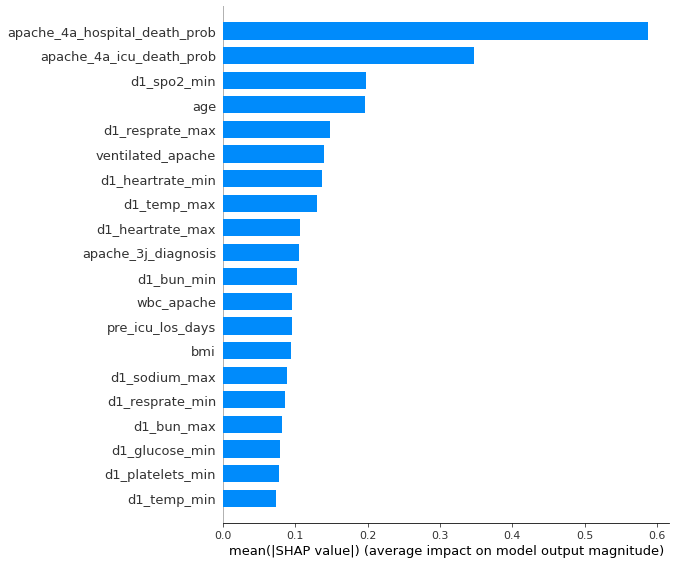

In [43]:
shap.summary_plot(shap_values, X_test_sample, plot_type="bar")

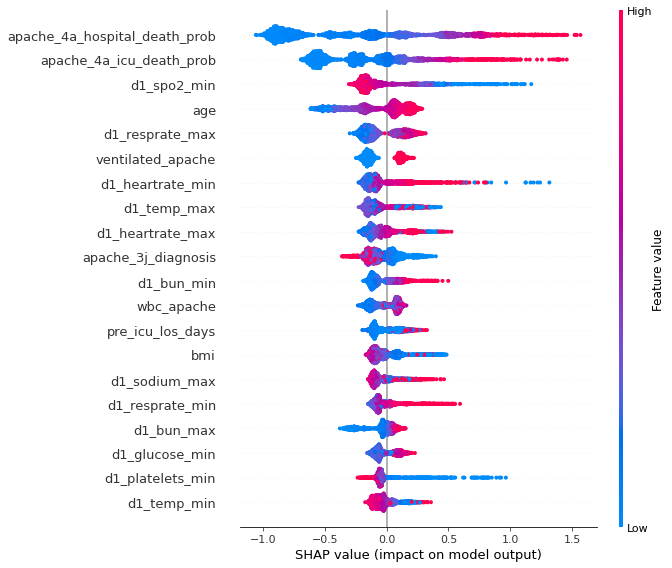

In [44]:
shap.summary_plot(shap_values, X_test_sample)

In [45]:
shap.initjs()
shap.force_plot(shap.TreeExplainer(xgb_tuned).expected_value, shap_values[0:257,:], X_test_sample.iloc[0:257,:])

In [46]:
shap.initjs()
print(y__hat[50])
shap.force_plot(shap.TreeExplainer(xgb_tuned).expected_value, shap_values[50], X_test_sample.iloc[50])

0


In [47]:
shap.initjs()
print(y__hat[21])
shap.force_plot(shap.TreeExplainer(xgb_tuned).expected_value, shap_values[21], X_test_sample.iloc[21])

1


In [48]:
shap.initjs()
print(y__hat[23])
shap.force_plot(shap.TreeExplainer(xgb_tuned).expected_value, shap_values[23], X_test_sample.iloc[23])

1


In [49]:
shap.initjs()
print(y__hat[60])
shap.force_plot(shap.TreeExplainer(xgb_tuned).expected_value, shap_values[60], X_test_sample.iloc[60])

0


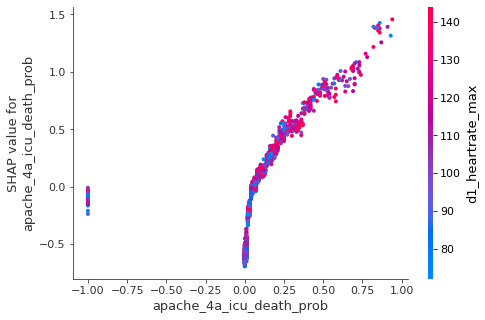

In [50]:
shap.initjs()
shap.dependence_plot('apache_4a_icu_death_prob', shap_values, X_test_sample)

**Impactful features fetched from Data Description after SHAP analysis to answer some questions about the dataset**

In [51]:
desc = pd.read_csv("/content/Data Dictionary.csv")
feats_ = ['apache_4a_icu_death_prob', 'apache_4a_hospital_death_prob', 'age', 'd1_spo2_min', 'd1_resprate_max', 'd1_heartrate_min', 'd1_temp_max', 'ventilated_apache', 'd1_bun_min','apache_3j_diagnosis', 'bmi']

desc[desc["Variable Name"].isin(feats_)][['Variable Name', 'Description']]

Variable Name  \
4                              age   
5                              bmi   
21             apache_3j_diagnosis   
45               ventilated_apache   
54                d1_heartrate_min   
61                 d1_resprate_max   
64                     d1_spo2_min   
71                     d1_temp_max   
104                     d1_bun_min   
175  apache_4a_hospital_death_prob   
176       apache_4a_icu_death_prob   

                                           Description  
4             The age of the patient on unit admission  
5    The body mass index of the person on unit admi...  
21   The APACHE III-J sub-diagnosis code which best...  
45   Whether the patient was invasively ventilated ...  
54   The patient's lowest heart rate during the fir...  
61   The patient's highest respiratory rate during ...  
64   The patient's lowest peripheral oxygen saturat...  
71   The patient's highest core temperature during ...  
104  The lowest blood urea nitrogen concentration o...  
175  The APACHE IVa probabilistic prediction of in-...  
176  The APACHE IVa probabilistic prediction of in ...

#### 1. What is the probability of a patient's survival after diagnosis?
The Survival of the patient is largely dependent upon the hospital reputaion and the icu ward where the patient is kept


<br>     
#### 2. What should be taken care of?
There is a codependency of the death rate and cardiovascular health of the patient



<br>     
#### 3. What is the scope of this project?
This project can serve as a hospital esteem stature. With more accurate data and better modelling procedure

# Saving the best estimator

In [52]:
import joblib

with open('./xgb_tuned_final.pkl.compressed', 'wb') as m:
    joblib.dump(xgb_tuned, m, compress=3)
    